In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from functions import apply_otsu

Try grain size analysis to identify rocks in an image.

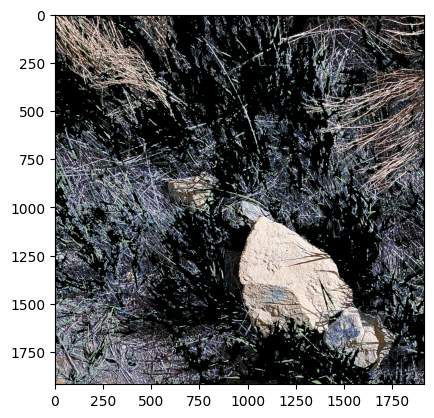

In [41]:
img_number = 25

# Load in RGBVI image that contains rocks
rgbvi_img = cv2.imread(f'results/cropped_rgbvi_gray/image_{img_number}.jpg', 0)

# Also load in the actual image
img = cv2.imread(f'test_photos_cropped/image_{img_number}.jpg')

# plt.hist(rgbvi_img.flatten(), bins = 100)

# Threshold it to only include plants
ret, thresh = cv2.threshold(rgbvi_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Define a kernel for morphological operations
kernel = np.ones((3,3), np.uint8)

# Dilate the image
img_dilated = cv2.dilate(thresh, kernel, iterations = 2)

# Then erode it
img_dilated_eroded = cv2.erode(img_dilated, kernel, iterations = 1)

# Invert the image so it'll capture everything but the plants
mask = cv2.bitwise_not(img_dilated_eroded)

img_masked = cv2.bitwise_and(img, img, mask = mask)


plt.imshow(img_masked)

# cv2.imshow('dilated', img_dilated)
# cv2.imshow('dilated and eroded', img_dilated_eroded)

# cv2.imshow('thresh', thresh)

# cv2.waitKey(0)
# cv2.destroyAllWindows()